# Tracking electoral con ponderación censal (Argentina)

Notebook de seguimiento para simular un tracking electoral con datos ficticios de tres encuestas mensuales. El flujo carga múltiples CSV, limpia los datos, pondera la muestra con referencias del Censo 2022 de Argentina (sexos, grupos de edad y estrato socioeconómico) y grafica la evolución de la imagen de *Candidato A* y de la intención de voto para tres candidatos.

## Librerías y configuración de gráficos

In [16]:
import math
from pathlib import Path
from typing import Dict, Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Distribución objetivo (Censo 2022)

A modo de ejemplo, usamos una distribución simplificada inspirada en el Censo 2022 (valores porcentuales aproximados). Se pueden reemplazar por tablas oficiales de INDEC si se cuenta con el detalle por sexo, grupo etario y estrato socioeconómico derivado de la canasta básica.

In [20]:
# Proporciones aproximadas (suman 1) para cruces sexo x grupo de edad x estrato.
census_distribution = pd.DataFrame(
    [
        {"sexo": "Femenino", "grupo_edad": "18-29", "estrato": "Bajo", "prop_objetivo": 0.055},
        {"sexo": "Femenino", "grupo_edad": "18-29", "estrato": "Medio", "prop_objetivo": 0.050},
        {"sexo": "Femenino", "grupo_edad": "18-29", "estrato": "Alto", "prop_objetivo": 0.015},
        {"sexo": "Femenino", "grupo_edad": "30-44", "estrato": "Bajo", "prop_objetivo": 0.065},
        {"sexo": "Femenino", "grupo_edad": "30-44", "estrato": "Medio", "prop_objetivo": 0.060},
        {"sexo": "Femenino", "grupo_edad": "30-44", "estrato": "Alto", "prop_objetivo": 0.020},
        {"sexo": "Femenino", "grupo_edad": "45-59", "estrato": "Bajo", "prop_objetivo": 0.050},
        {"sexo": "Femenino", "grupo_edad": "45-59", "estrato": "Medio", "prop_objetivo": 0.055},
        {"sexo": "Femenino", "grupo_edad": "45-59", "estrato": "Alto", "prop_objetivo": 0.020},
        {"sexo": "Femenino", "grupo_edad": "60+", "estrato": "Bajo", "prop_objetivo": 0.040},
        {"sexo": "Femenino", "grupo_edad": "60+", "estrato": "Medio", "prop_objetivo": 0.045},
        {"sexo": "Femenino", "grupo_edad": "60+", "estrato": "Alto", "prop_objetivo": 0.015},
        {"sexo": "Masculino", "grupo_edad": "18-29", "estrato": "Bajo", "prop_objetivo": 0.055},
        {"sexo": "Masculino", "grupo_edad": "18-29", "estrato": "Medio", "prop_objetivo": 0.060},
        {"sexo": "Masculino", "grupo_edad": "18-29", "estrato": "Alto", "prop_objetivo": 0.015},
        {"sexo": "Masculino", "grupo_edad": "30-44", "estrato": "Bajo", "prop_objetivo": 0.065},
        {"sexo": "Masculino", "grupo_edad": "30-44", "estrato": "Medio", "prop_objetivo": 0.070},
        {"sexo": "Masculino", "grupo_edad": "30-44", "estrato": "Alto", "prop_objetivo": 0.020},
        {"sexo": "Masculino", "grupo_edad": "45-59", "estrato": "Bajo", "prop_objetivo": 0.050},
        {"sexo": "Masculino", "grupo_edad": "45-59", "estrato": "Medio", "prop_objetivo": 0.055},
        {"sexo": "Masculino", "grupo_edad": "45-59", "estrato": "Alto", "prop_objetivo": 0.020},
        {"sexo": "Masculino", "grupo_edad": "60+", "estrato": "Bajo", "prop_objetivo": 0.040},
        {"sexo": "Masculino", "grupo_edad": "60+", "estrato": "Medio", "prop_objetivo": 0.045},
        {"sexo": "Masculino", "grupo_edad": "60+", "estrato": "Alto", "prop_objetivo": 0.015},
    ]
)
assert math.isclose(census_distribution["prop_objetivo"].sum(), 1.0, rel_tol=1e-6), "La distribución objetivo debe sumar 1"

## Utilidades de limpieza y ponderación

In [21]:
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


def normalizar_estrato(valor: str) -> str:
    if pd.isna(valor):
        return None
    valor = valor.strip().lower()
    if valor.startswith("b"):
        return "Bajo"
    if valor.startswith("m"):
        return "Medio"
    if valor.startswith("a"):
        return "Alto"
    return None


def normalizar_sexo(valor: str) -> str:
    if pd.isna(valor):
        return None
    valor = valor.strip().lower()
    if valor.startswith("f"):
        return "Femenino"
    if valor.startswith("m"):
        return "Masculino"
    return None


def agrupar_edad(edad: float) -> str:
    if pd.isna(edad):
        return None
    edad = float(edad)
    if edad < 18:
        return None
    if edad <= 29:
        return "18-29"
    if edad <= 44:
        return "30-44"
    if edad <= 59:
        return "45-59"
    return "60+"


def cargar_encuestas(ruta: Path) -> pd.DataFrame:
    archivos = sorted(ruta.glob("encuestas_*.csv"))
    if not archivos:
        raise FileNotFoundError("No se encontraron archivos encuestas_*.csv en el directorio de datos")

    frames = []
    for archivo in archivos:
        df = pd.read_csv(archivo, parse_dates=["Fecha"], dayfirst=False)
        df["archivo"] = archivo.name
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def limpiar_encuestas(df: pd.DataFrame) -> pd.DataFrame:
    base = df.copy()
    base["Estrato"] = base["Estrato"].apply(normalizar_estrato)
    base["Sexo"] = base["Sexo"].apply(normalizar_sexo)
    base["grupo_edad"] = base["Edad"].apply(agrupar_edad)
    base["Voto"] = base["Voto"].str.strip().str.title()
    base["Voto Anterior"] = base["Voto Anterior"].str.strip().str.title()
    base["Imagen del Candidato"] = pd.to_numeric(base["Imagen del Candidato"], errors="coerce")

    # Descarta registros incompletos para la ponderación
    base = base.dropna(subset=["Estrato", "Sexo", "grupo_edad", "Imagen del Candidato", "Voto"])
    return base


def calcular_pesos_muestrales(df: pd.DataFrame, distribucion_objetivo: pd.DataFrame) -> pd.DataFrame:
    claves = ["Sexo", "grupo_edad", "Estrato"]
    df_claves = df.rename(columns={"Sexo": "sexo", "Estrato": "estrato"})

    muestra = df_claves.groupby(["sexo", "grupo_edad", "estrato"]).size().reset_index(name="n_muestra")
    muestra["prop_muestra"] = muestra["n_muestra"] / muestra["n_muestra"].sum()

    mergeado = distribucion_objetivo.merge(muestra, how="left", on=["sexo", "grupo_edad", "estrato"])
    mergeado["prop_muestra"].fillna(0, inplace=True)
    mergeado["peso"] = mergeado.apply(
        lambda fila: fila["prop_objetivo"] / fila["prop_muestra"] if fila["prop_muestra"] > 0 else 0,
        axis=1,
    )

    pesos = mergeado[["sexo", "grupo_edad", "estrato", "peso"]]
    df_pesado = df_claves.merge(pesos, how="left", on=["sexo", "grupo_edad", "estrato"])
    df_pesado["peso"].fillna(0, inplace=True)
    return df_pesado.rename(columns={"sexo": "Sexo", "estrato": "Estrato"})

## Cargar y preparar la base unificada

In [22]:
encuestas_raw = cargar_encuestas(DATA_DIR)
encuestas_limpias = limpiar_encuestas(encuestas_raw)
encuestas_pesadas = calcular_pesos_muestrales(encuestas_limpias, census_distribution)
encuestas_pesadas.head()

C:\Users\20396439973\AppData\Local\Temp\ipykernel_5696\3382299412.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mergeado["prop_muestra"].fillna(0, inplace=True)
C:\Users\20396439973\AppData\Local\Temp\ipykernel_5696\3382299412.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

,Fecha,Encuesta,Estrato,Sexo,Edad,Nivel Educativo,Cantidad de Integrantes en el Hogar,Imagen del Candidato,Voto,Voto Anterior,archivo,grupo_edad,peso
0,2024-01-15,ENC-2024-01-001,Bajo,Femenino,28,Secundario completo,4,62,Candidato A,Candidato B,encuestas_2024-01.csv,18-29,0.4950
1,2024-01-15,ENC-2024-01-002,Medio,Masculino,35,Universitario incompleto,3,58,Candidato B,Candidato B,encuestas_2024-01.csv,30-44,0.7875
2,2024-01-15,ENC-2024-01-003,Alto,Masculino,46,Universitario completo,2,71,Candidato A,Candidato A,encuestas_2024-01.csv,45-59,0.3000
3,2024-01-15,ENC-2024-01-004,Medio,Femenino,54,Secundario completo,5,64,Candidato C,Candidato C,encuestas_2024-01.csv,45-59,0.4950
4,2024-01-15,ENC-2024-01-005,Bajo,Femenino,22,Secundario incompleto,3,55,Candidato A,Candidato A,encuestas_2024-01.csv,18-29,0.4950


## Funciones de agregación y ventana móvil

In [23]:
def media_ponderada(df: pd.DataFrame, valor_col: str, peso_col: str) -> float:
    if df[peso_col].sum() == 0:
        return float("nan")
    return (df[valor_col] * df[peso_col]).sum() / df[peso_col].sum()


def evolucion_imagen(df: pd.DataFrame, candidato_objetivo: str, ventana: int = 2) -> pd.DataFrame:
    filtro = df[df["Voto"] == candidato_objetivo]
    serie = (
        filtro.groupby("Fecha")
        .apply(lambda x: media_ponderada(x, "Imagen del Candidato", "peso"))
        .reset_index(name="imagen_media")
        .sort_values("Fecha")
    )
    serie["imagen_suavizada"] = serie["imagen_media"].rolling(window=ventana, min_periods=1).mean()
    return serie


def evolucion_voto(df: pd.DataFrame, ventana: int = 2) -> pd.DataFrame:
    totales = df.groupby(["Fecha", "Voto"]).agg({"peso": "sum"}).reset_index()
    totales["peso_total"] = totales.groupby("Fecha")["peso"].transform("sum")
    totales["voto_pct"] = (totales["peso"] / totales["peso_total"]) * 100

    totales = totales.sort_values("Fecha")
    totales["voto_suavizado"] = (
        totales.groupby("Voto")["voto_pct"].transform(lambda s: s.rolling(window=ventana, min_periods=1).mean())
    )
    return totales

## Calcular series de tiempo ponderadas

In [24]:
CANDIDATO_OBJETIVO = "Candidato A"
VENTANA = 2

serie_imagen = evolucion_imagen(encuestas_pesadas, candidato_objetivo=CANDIDATO_OBJETIVO, ventana=VENTANA)
serie_voto = evolucion_voto(encuestas_pesadas, ventana=VENTANA)

serie_imagen

C:\Users\20396439973\AppData\Local\Temp\ipykernel_5696\541834174.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: media_ponderada(x, "Imagen del Candidato", "peso"))


,Fecha,imagen_media,imagen_suavizada
0,2024-01-15,62.670886,62.670886
1,2024-02-15,63.662791,63.166838
2,2024-03-15,64.447293,64.055042


## Gráficos: imagen del candidato y voto por candidato

WindowsPath('outputs/imagen_candidato.png')

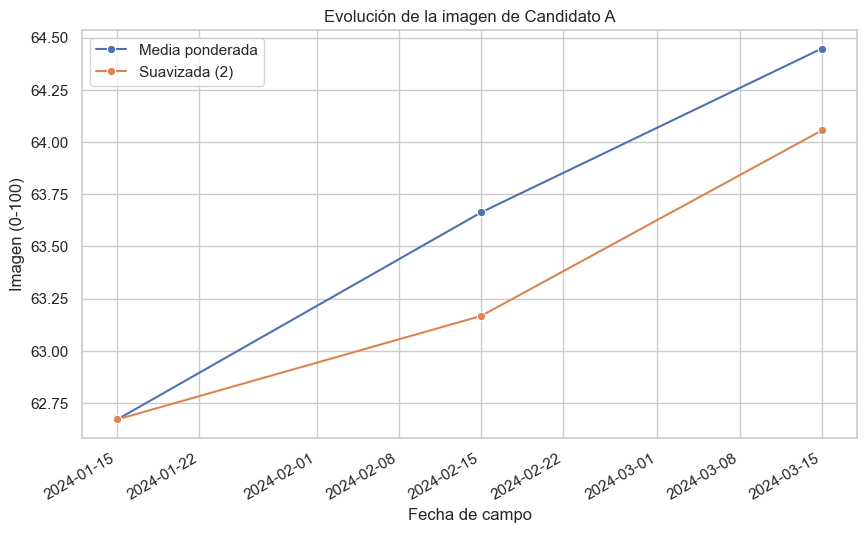

In [25]:
fig1, ax1 = plt.subplots()
sns.lineplot(data=serie_imagen, x="Fecha", y="imagen_media", marker="o", label="Media ponderada", ax=ax1)
sns.lineplot(data=serie_imagen, x="Fecha", y="imagen_suavizada", marker="o", label=f"Suavizada ({VENTANA})", ax=ax1)
ax1.set_title(f"Evolución de la imagen de {CANDIDATO_OBJETIVO}")
ax1.set_ylabel("Imagen (0-100)")
ax1.set_xlabel("Fecha de campo")
fig1.autofmt_xdate()
img_path = OUTPUT_DIR / "imagen_candidato.png"
fig1.savefig(img_path, dpi=150, bbox_inches="tight")
img_path

WindowsPath('outputs/intencion_voto.png')

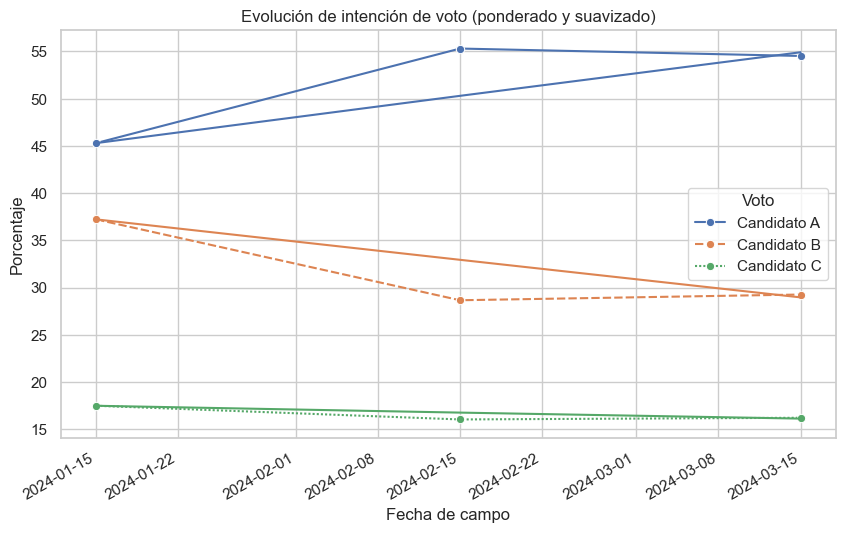

In [26]:
fig2, ax2 = plt.subplots()
sns.lineplot(data=serie_voto, x="Fecha", y="voto_pct", hue="Voto", style="Voto", marker="o", ax=ax2)
sns.lineplot(data=serie_voto, x="Fecha", y="voto_suavizado", hue="Voto", style=True, dashes=True, legend=False, ax=ax2)
ax2.set_title("Evolución de intención de voto (ponderado y suavizado)")
ax2.set_ylabel("Porcentaje")
ax2.set_xlabel("Fecha de campo")
fig2.autofmt_xdate()
voto_path = OUTPUT_DIR / "intencion_voto.png"
fig2.savefig(voto_path, dpi=150, bbox_inches="tight")
voto_path

## Uso en VSCode

1. Abre este repositorio en VSCode y abre `tracking_electoral.ipynb`.
2. Instala las dependencias en un entorno de Python 3.10+: `pip install pandas matplotlib seaborn`.
3. Ejecuta las celdas en orden. Las gráficas se guardan en `outputs/imagen_candidato.png` e `outputs/intencion_voto.png` para referencia rápida.
4. Para actualizar la simulación, agrega nuevos CSV en `data/` siguiendo el patrón `encuestas_YYYY-MM.csv` y vuelve a ejecutar las celdas.